#Install Kaggle and Import Libraries

In [1]:
# Install Kaggle
!pip install kaggle

# Import necessary libraries
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil


#Setup Kaggle API in Google Colab

In [2]:
import os
import json

# Save the uploaded kaggle.json to the appropriate directory
kaggle_json_path = '/content/kaggle.json'
with open(kaggle_json_path, 'w') as file:
    json.dump({
        "username": "varadladbtech2022",  # Username from your kaggle.json
        "key": "6ea52e58d6c50a3ccd0a5884221ba60f"  # API key from your kaggle.json
    }, file)

# Create the .kaggle directory and copy the kaggle.json file into it
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Set permissions to the kaggle.json file
!chmod 600 ~/.kaggle/kaggle.json

# Verify that Kaggle is set up correctly
!kaggle datasets list


ref                                                           title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
lainguyn123/student-performance-factors                       Student Performance Factors                         94KB  2024-09-02 10:53:57          29338        519  1.0              
valakhorasani/mobile-device-usage-and-user-behavior-dataset   Mobile Device Usage and User Behavior Dataset       11KB  2024-09-28 20:21:12           3835         71  1.0              
abdulszz/spotify-most-streamed-songs                          Spotify Most Streamed Songs                         60KB  2024-09-07 18:23:14          11243        147  1.0              
prajwaldongre/top-50-luxury-hotels-worldwide                  Top 50 Luxury

#Download the Dataset

In [3]:
# Download the chest X-ray dataset
!kaggle datasets download -d jtiptj/chest-xray-pneumoniacovid19tuberculosis

# Unzip the downloaded dataset
!unzip chest-xray-pneumoniacovid19tuberculosis.zip -d chest_xray_data

# Remove the zip file to free up space
!rm chest-xray-pneumoniacovid19tuberculosis.zip


Streaming output truncated to the last 5000 lines.
  inflating: chest_xray_data/train/NORMAL/NORMAL2-IM-0843-0001.jpeg  
  inflating: chest_xray_data/train/NORMAL/NORMAL2-IM-0845-0001.jpeg  
  inflating: chest_xray_data/train/NORMAL/NORMAL2-IM-0846-0001.jpeg  
  inflating: chest_xray_data/train/NORMAL/NORMAL2-IM-0847-0001.jpeg  
  inflating: chest_xray_data/train/NORMAL/NORMAL2-IM-0848-0001.jpeg  
  inflating: chest_xray_data/train/NORMAL/NORMAL2-IM-0849-0001.jpeg  
  inflating: chest_xray_data/train/NORMAL/NORMAL2-IM-0851-0001-0001.jpeg  
  inflating: chest_xray_data/train/NORMAL/NORMAL2-IM-0851-0001-0002.jpeg  
  inflating: chest_xray_data/train/NORMAL/NORMAL2-IM-0851-0001.jpeg  
  inflating: chest_xray_data/train/NORMAL/NORMAL2-IM-0852-0001.jpeg  
  inflating: chest_xray_data/train/NORMAL/NORMAL2-IM-0853-0001.jpeg  
  inflating: chest_xray_data/train/NORMAL/NORMAL2-IM-0854-0001.jpeg  
  inflating: chest_xray_data/train/NORMAL/NORMAL2-IM-0855-0001.jpeg  
  inflating: chest_xray_data/

#Data Preprocessing and Augmentation

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers

# Define image size and batch size
IMG_SIZE = (256, 256)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# Load the training dataset (80% training, 20% validation)
train_ds = image_dataset_from_directory(
    'chest_xray_data/train',
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'  # Multi-class classification
)

val_ds = image_dataset_from_directory(
    'chest_xray_data/train',
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

# Load the test dataset
test_ds = image_dataset_from_directory(
    'chest_xray_data/test',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

# Apply prefetching to optimize performance
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])


Found 6326 files belonging to 4 classes.
Using 5061 files for training.
Found 6326 files belonging to 4 classes.
Using 1265 files for validation.
Found 771 files belonging to 4 classes.


#Model Creation with Hyperparameter Tuning using Keras Tuner

In [5]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.2 MB/s eta 0:00:00


In [6]:
!pip install keras-tuner
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping
from kerastuner.tuners import RandomSearch  # Import RandomSearch from kerastuner

from tensorflow.keras.callbacks import EarlyStopping

# Define the model building function for Keras Tuner
def build_model(hp):
    model = models.Sequential()

    # Data augmentation and rescaling
    model.add(data_augmentation)
    model.add(layers.Rescaling(1./255))

    # Add convolutional layers with hyperparameter tuning
    for i in range(hp.Int('conv_layers', 2, 3)):  # Reduced range to 2 or 3 conv layers
        model.add(layers.Conv2D(
            filters=hp.Choice(f'filters_{i}', values=[32, 64]),  # Fewer filter options
            kernel_size=(3, 3),
            activation='relu'
        ))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Flatten and fully connected layers
    model.add(layers.Flatten())
    model.add(layers.Dense(
        units=hp.Int('dense_units', min_value=128, max_value=256, step=128),  # Fewer units to search
        activation='relu'
    ))
    model.add(layers.Dropout(rate=hp.Float('dropout', 0.3, 0.4, step=0.1)))  # Narrower dropout range

    # Output layer
    model.add(layers.Dense(4, activation='softmax'))

    # Compile the model
    model.compile(
        optimizer=optimizers.Adam(hp.Choice('learning_rate', values=[1e-3, 1e-4])),  # Removed 1e-2 to focus on smaller values
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Implement early stopping to stop training if validation accuracy doesn't improve for 3 epochs
early_stop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

# Initialize Keras Tuner with fewer trials and epochs
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # Fewer trials
    executions_per_trial=1,  # Fewer executions per trial
    directory='tuner_results',
    project_name='chest_xray_classification'
)

# Run the hyperparameter search with fewer epochs
tuner.search(train_ds, epochs=5, validation_data=val_ds, callbacks=[early_stop])  # Reduced epochs to 5


Trial 5 Complete [01h 55m 54s]
val_accuracy: 0.9003952741622925

Best val_accuracy So Far: 0.9209486246109009
Total elapsed time: 06h 57m 34s


#Train the Best Model

In [7]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the best model
best_model = tuner.hypermodel.build(best_hps)

# Train the best model
history = best_model.fit(train_ds, epochs=3, validation_data=val_ds)


Epoch 1/3
159/159 ━━━━━━━━━━━━━━━━━━━━ 668s 4s/step - accuracy: 0.6278 - loss: 1.0828 - val_accuracy: 0.8538 - val_loss: 0.3857
Epoch 2/3
159/159 ━━━━━━━━━━━━━━━━━━━━ 632s 4s/step - accuracy: 0.8284 - loss: 0.4433 - val_accuracy: 0.7700 - val_loss: 0.5063
Epoch 3/3
159/159 ━━━━━━━━━━━━━━━━━━━━ 681s 4s/step - accuracy: 0.8549 - loss: 0.3812 - val_accuracy: 0.9107 - val_loss: 0.2411


#Evaluate the Model

In [8]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Evaluate the model on the test set
test_loss, test_acc = best_model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Generate predictions on the test set
y_true = []
y_pred = []
for images, labels in test_ds:
    preds = best_model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# Define class names
class_names = ['NORMAL', 'COVID-19', 'PNEUMONIA', 'TUBERCULOSIS']

# Classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", conf_matrix)


25/25 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.7954 - loss: 0.4959
Test Accuracy: 80.03%
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 908ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 958ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 853ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 937ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 991ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 911ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 907ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 892ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step
1/

#Plot Metrics and Confusion Matrix

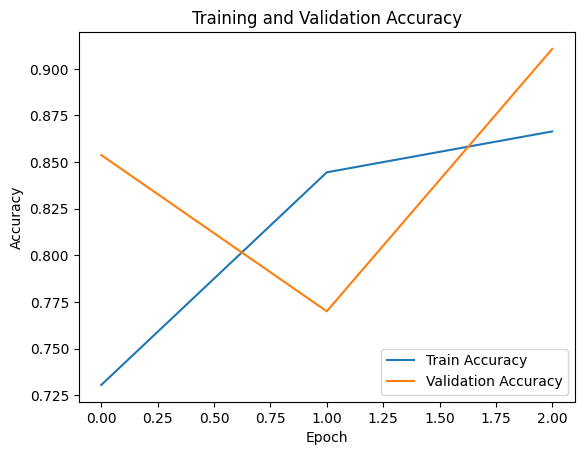

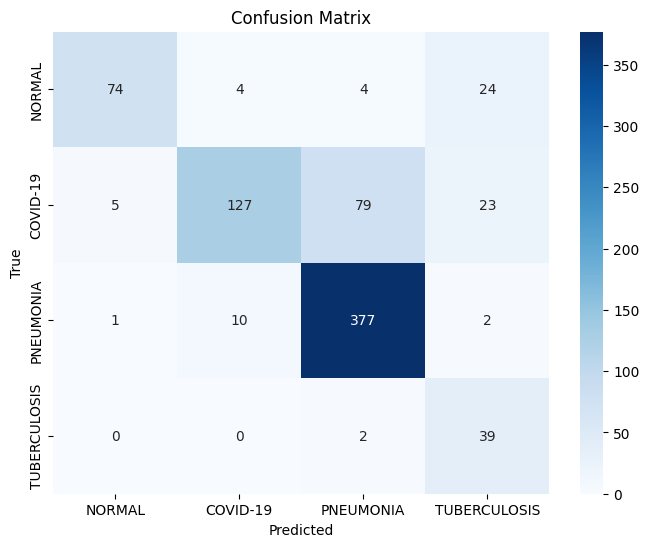

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


#Save the Model

In [15]:
!pip install dill

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 2.5 MB/s eta 0:00:00


In [16]:
import tensorflow as tf
import dill

# Save the model to a file
model_save_path = '/content/chest_xray_model.h5'

# Use dill instead of pickle to serialize the model
def save_model_with_dill(model, filepath):
  with open(filepath, 'wb') as f:
    dill.dump(model, f)

# Try saving the model using dill
save_model_with_dill(best_model, model_save_path)
print(f"Model saved at: {model_save_path}")

# To load the model later, use:
# with open(model_save_path, 'rb') as f:
#   loaded_model = dill.load(f)

Model saved at: /content/chest_xray_model.h5
